In [2]:
# point Python to your src folder and import the module
import sys, importlib, os

# adjust if your path is different
SRC_DIR = "disaster-ai/src"
assert os.path.exists(os.path.join(SRC_DIR, "cv_dataset.py")), "cv_dataset.py not found under disaster-ai/src"

if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

import cv_dataset
importlib.reload(cv_dataset)

from cv_dataset import XBDDamageDataset, CLASSES, _find_label_path

print("Loaded:", cv_dataset.__file__)
print("Classes:", CLASSES)

Loaded: /Users/rudrabrahmbhatt/Documents/AI_Powered_Disaster_Response_&_Resource_Allocation/disaster-ai/src/cv_dataset.py
Classes: ['no-damage', 'minor-damage', 'major-damage', 'destroyed']


In [14]:
# Probe 1: print first 40 raw labels to see variety
for i in range(40):
    _, y = ds_tr_full[i]   # NOTE: use the *full* train dataset, not the subset
    print(i, type(y), y)

# Probe 2: unique labels across a wider slice
uniq = set()
for i in range(min(5000, len(ds_tr_full))):
    _, y = ds_tr_full[i]
    try:
        uniq.add(int(y))
    except Exception:
        uniq.add(y)
print("Unique labels seen:", uniq)

0 <class 'torch.Tensor'> tensor(0)
1 <class 'torch.Tensor'> tensor(0)
2 <class 'torch.Tensor'> tensor(0)
3 <class 'torch.Tensor'> tensor(0)
4 <class 'torch.Tensor'> tensor(0)
5 <class 'torch.Tensor'> tensor(0)
6 <class 'torch.Tensor'> tensor(0)
7 <class 'torch.Tensor'> tensor(0)
8 <class 'torch.Tensor'> tensor(0)
9 <class 'torch.Tensor'> tensor(0)
10 <class 'torch.Tensor'> tensor(0)
11 <class 'torch.Tensor'> tensor(0)
12 <class 'torch.Tensor'> tensor(0)
13 <class 'torch.Tensor'> tensor(0)
14 <class 'torch.Tensor'> tensor(0)
15 <class 'torch.Tensor'> tensor(0)
16 <class 'torch.Tensor'> tensor(0)
17 <class 'torch.Tensor'> tensor(0)
18 <class 'torch.Tensor'> tensor(0)
19 <class 'torch.Tensor'> tensor(0)
20 <class 'torch.Tensor'> tensor(0)
21 <class 'torch.Tensor'> tensor(0)
22 <class 'torch.Tensor'> tensor(0)
23 <class 'torch.Tensor'> tensor(0)
24 <class 'torch.Tensor'> tensor(0)
25 <class 'torch.Tensor'> tensor(0)
26 <class 'torch.Tensor'> tensor(0)
27 <class 'torch.Tensor'> tensor(0)
28

In [16]:
# Peek a few samples to inspect the file path and label
for i in range(10):
    x, y = ds_tr_full[i]
    print(i, getattr(getattr(x, 'size', None), '__repr__', lambda: '?')(), y)

0 <built-in method size of Tensor object at 0x16802cb40> tensor(0)
1 <built-in method size of Tensor object at 0x1692e4dc0> tensor(0)
2 <built-in method size of Tensor object at 0x16802cb40> tensor(0)
3 <built-in method size of Tensor object at 0x1692e5ef0> tensor(0)
4 <built-in method size of Tensor object at 0x16802cb40> tensor(0)
5 <built-in method size of Tensor object at 0x1692e4370> tensor(0)
6 <built-in method size of Tensor object at 0x16802cb40> tensor(0)
7 <built-in method size of Tensor object at 0x1692e5ae0> tensor(0)
8 <built-in method size of Tensor object at 0x16802cb40> tensor(0)
9 <built-in method size of Tensor object at 0x1692e6490> tensor(0)


In [34]:
# --- CONFIG ---
import os, json, re, random, glob, csv
from PIL import Image
import torch
from torch.utils.data import Dataset, Subset, DataLoader

DATA_DIR = "disaster-ai/data/xbd/tier1"   # <-- point this to your tier1 folder
SEED = 42
CLASSES = ['no-damage','minor-damage','major-damage','destroyed']
CLASS_TO_ID = {c:i for i,c in enumerate(CLASSES)}
IMG_EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

random.seed(SEED)

# --- STEP 1: make train.jsonl & val.jsonl from per-image JSONs in labels/ ---
labels_dir = os.path.join(DATA_DIR, "labels")
images_dir = os.path.join(DATA_DIR, "images")
out_train = os.path.join(DATA_DIR, "train.jsonl")
out_val   = os.path.join(DATA_DIR, "val.jsonl")

def read_json(path):
    with open(path, "r") as f:
        return json.load(f)

def find_damage_anywhere(obj):
    """
    Recursively search for a string value equal to one of the class names
    under common keys like 'damage', 'damage_status', 'label', 'class', etc.
    Returns normalized label or None.
    """
    stack = [obj]
    while stack:
        cur = stack.pop()
        if isinstance(cur, dict):
            for k, v in cur.items():
                if isinstance(v, str):
                    s = re.sub(r'\s+', '-', v.strip().lower())
                    if s in CLASS_TO_ID:
                        return s
                elif isinstance(v, (dict, list)):
                    stack.append(v)
        elif isinstance(cur, list):
            stack.extend(cur)
    return None

def build_index(split_ratio=0.8):
    """
    Scans labels/*.json, matches to images/*.png|jpg, keeps only *_post_disaster.*
    Returns two lists of dicts: [{image_path, damage}, ...] for train/val.
    """
    label_files = sorted(glob.glob(os.path.join(labels_dir, "*.json")))
    records = []

    for jpath in label_files:
        fname = os.path.basename(jpath)             # e.g., "socal-fire_00001396_post_disaster.json"
        base = os.path.splitext(fname)[0]           # socal-fire_00001396_post_disaster
        # prefer post_disaster only for damage classification
        if "_post_disaster" not in base:
            continue

        dmg = find_damage_anywhere(read_json(jpath))
        if dmg is None:
            # skip unknown / unlabeled samples
            continue

        # image path candidates
        for ext in IMG_EXTS:
            ipath = os.path.join(images_dir, base + ext)
            if os.path.isfile(ipath):
                records.append({"image_path": os.path.relpath(ipath, DATA_DIR),
                                "damage": dmg})
                break
        # if not found, try some common alternative filenames (some sets add suffixes)
        # (add more heuristics here if needed)

    if not records:
        raise RuntimeError("No labeled post_disaster samples found. Check DATA_DIR paths.")

    # shuffle & split
    random.shuffle(records)
    n_train = int(len(records) * split_ratio)
    train_recs = records[:n_train]
    val_recs   = records[n_train:]
    return train_recs, val_recs

train_recs, val_recs = build_index(split_ratio=0.8)

def write_jsonl(path, rows):
    with open(path, "w") as f:
        for r in rows:
            f.write(json.dumps(r) + "\n")

write_jsonl(out_train, train_recs)
write_jsonl(out_val,   val_recs)

print(f"Wrote {len(train_recs)} → {out_train}")
print(f"Wrote {len(val_recs)}   → {out_val}")

# quick distribution check
def counts(rows):
    c = {k:0 for k in CLASSES}
    for r in rows: c[r["damage"]] += 1
    return c
print("Train class counts (raw):", counts(train_recs))
print("Val   class counts (raw):", counts(val_recs))

# --- STEP 2: dataset for JSONL annotations ---
def _norm_label(s): return re.sub(r'\s+', '-', s.strip().lower())

class LabeledImages(Dataset):
    def __init__(self, ann_file, root, transform=None, exts=IMG_EXTS, verbose=True):
        self.root = root
        self.tf = transform
        self.exts = tuple(e.lower() for e in exts)
        self.items = []
        n_total = 0
        with open(ann_file, "r") as f:
            for line in f:
                n_total += 1
                obj = json.loads(line)
                p = obj["image_path"]
                lab = _norm_label(obj["damage"])
                if lab not in CLASS_TO_ID:
                    continue
                ipath = p if os.path.isabs(p) else os.path.join(root, p)
                if not os.path.isfile(ipath):
                    continue
                self.items.append((ipath, CLASS_TO_ID[lab]))
        if verbose:
            print(f"[{os.path.basename(ann_file)}] kept {len(self.items)} / {n_total}")
            cnt = torch.zeros(len(CLASSES), dtype=torch.long)
            for _, y in self.items: cnt[y] += 1
            print("Class counts:", dict(zip(CLASSES, cnt.tolist())))

    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        p, y = self.items[i]
        img = Image.open(p).convert("RGB")
        if self.tf: img = self.tf(img)
        return img, y

# --- STEP 3: build balanced (stratified) subsets ---
def build_stratified_subset(dataset, limit=None, seed=SEED):
    rng = random.Random(seed)
    idx_by_class = {c: [] for c in range(len(CLASSES))}
    for i in range(len(dataset)):
        _, y = dataset[i]
        idx_by_class[int(y)].append(i)
    empty = [CLASSES[c] for c, lst in idx_by_class.items() if len(lst) == 0]
    if empty:
        raise RuntimeError(f"No samples for classes: {empty}. Re-check labels parsing.")
    if limit is None:
        per = min(len(v) for v in idx_by_class.values())
        tgt = {c: per for c in idx_by_class}
    else:
        k = len(CLASSES); base = limit // k; rem = limit % k
        tgt = {c: base + (1 if c < rem else 0) for c in range(k)}
    chosen = []
    for c, pool in idx_by_class.items():
        rng.shuffle(pool)
        chosen.extend(pool[:min(tgt[c], len(pool))])
    rng.shuffle(chosen)
    return Subset(dataset, chosen)

# instantiate datasets using the JSONLs we just created
ds_tr_full = LabeledImages(out_train, DATA_DIR, transform=None, verbose=True)
ds_va_full = LabeledImages(out_val,   DATA_DIR, transform=None, verbose=True)

# choose sizes that fit your GPU/time budget
ds_tr = build_stratified_subset(ds_tr_full, limit=2000, seed=SEED)
ds_va = build_stratified_subset(ds_va_full, limit=1600, seed=SEED)

# sanity check
def class_counts(ds):
    cnt = torch.zeros(len(CLASSES), dtype=torch.long)
    for i in range(len(ds)):
        _, y = ds[i]; cnt[int(y)] += 1
    return dict(zip(CLASSES, cnt.tolist()))

print("Train class counts (balanced):", class_counts(ds_tr))
print("Val   class counts (balanced):", class_counts(ds_va))

# --- STEP 4: build DataLoaders ---
train_dl = DataLoader(ds_tr, batch_size=64, shuffle=True,  num_workers=4, pin_memory=True)
val_dl   = DataLoader(ds_va, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

Wrote 1792 → disaster-ai/data/xbd/tier1/train.jsonl
Wrote 448   → disaster-ai/data/xbd/tier1/val.jsonl
Train class counts (raw): {'no-damage': 1042, 'minor-damage': 166, 'major-damage': 247, 'destroyed': 337}
Val   class counts (raw): {'no-damage': 261, 'minor-damage': 42, 'major-damage': 61, 'destroyed': 84}
[train.jsonl] kept 1792 / 1792
Class counts: {'no-damage': 1042, 'minor-damage': 166, 'major-damage': 247, 'destroyed': 337}
[val.jsonl] kept 448 / 448
Class counts: {'no-damage': 261, 'minor-damage': 42, 'major-damage': 61, 'destroyed': 84}
Train class counts (balanced): {'no-damage': 500, 'minor-damage': 166, 'major-damage': 247, 'destroyed': 337}
Val   class counts (balanced): {'no-damage': 261, 'minor-damage': 42, 'major-damage': 61, 'destroyed': 84}


In [34]:
# --- CONFIG ---
import os, json, re, random, glob, csv
from PIL import Image
import torch
from torch.utils.data import Dataset, Subset, DataLoader

DATA_DIR = "disaster-ai/data/xbd/tier1"   # <-- point this to your tier1 folder
SEED = 42
CLASSES = ['no-damage','minor-damage','major-damage','destroyed']
CLASS_TO_ID = {c:i for i,c in enumerate(CLASSES)}
IMG_EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

random.seed(SEED)

# --- STEP 1: make train.jsonl & val.jsonl from per-image JSONs in labels/ ---
labels_dir = os.path.join(DATA_DIR, "labels")
images_dir = os.path.join(DATA_DIR, "images")
out_train = os.path.join(DATA_DIR, "train.jsonl")
out_val   = os.path.join(DATA_DIR, "val.jsonl")

def read_json(path):
    with open(path, "r") as f:
        return json.load(f)

def find_damage_anywhere(obj):
    """
    Recursively search for a string value equal to one of the class names
    under common keys like 'damage', 'damage_status', 'label', 'class', etc.
    Returns normalized label or None.
    """
    stack = [obj]
    while stack:
        cur = stack.pop()
        if isinstance(cur, dict):
            for k, v in cur.items():
                if isinstance(v, str):
                    s = re.sub(r'\s+', '-', v.strip().lower())
                    if s in CLASS_TO_ID:
                        return s
                elif isinstance(v, (dict, list)):
                    stack.append(v)
        elif isinstance(cur, list):
            stack.extend(cur)
    return None

def build_index(split_ratio=0.8):
    """
    Scans labels/*.json, matches to images/*.png|jpg, keeps only *_post_disaster.*
    Returns two lists of dicts: [{image_path, damage}, ...] for train/val.
    """
    label_files = sorted(glob.glob(os.path.join(labels_dir, "*.json")))
    records = []

    for jpath in label_files:
        fname = os.path.basename(jpath)             # e.g., "socal-fire_00001396_post_disaster.json"
        base = os.path.splitext(fname)[0]           # socal-fire_00001396_post_disaster
        # prefer post_disaster only for damage classification
        if "_post_disaster" not in base:
            continue

        dmg = find_damage_anywhere(read_json(jpath))
        if dmg is None:
            # skip unknown / unlabeled samples
            continue

        # image path candidates
        for ext in IMG_EXTS:
            ipath = os.path.join(images_dir, base + ext)
            if os.path.isfile(ipath):
                records.append({"image_path": os.path.relpath(ipath, DATA_DIR),
                                "damage": dmg})
                break
        # if not found, try some common alternative filenames (some sets add suffixes)
        # (add more heuristics here if needed)

    if not records:
        raise RuntimeError("No labeled post_disaster samples found. Check DATA_DIR paths.")

    # shuffle & split
    random.shuffle(records)
    n_train = int(len(records) * split_ratio)
    train_recs = records[:n_train]
    val_recs   = records[n_train:]
    return train_recs, val_recs

train_recs, val_recs = build_index(split_ratio=0.8)

def write_jsonl(path, rows):
    with open(path, "w") as f:
        for r in rows:
            f.write(json.dumps(r) + "\n")

write_jsonl(out_train, train_recs)
write_jsonl(out_val,   val_recs)

print(f"Wrote {len(train_recs)} → {out_train}")
print(f"Wrote {len(val_recs)}   → {out_val}")

# quick distribution check
def counts(rows):
    c = {k:0 for k in CLASSES}
    for r in rows: c[r["damage"]] += 1
    return c
print("Train class counts (raw):", counts(train_recs))
print("Val   class counts (raw):", counts(val_recs))

# --- STEP 2: dataset for JSONL annotations ---
def _norm_label(s): return re.sub(r'\s+', '-', s.strip().lower())

class LabeledImages(Dataset):
    def __init__(self, ann_file, root, transform=None, exts=IMG_EXTS, verbose=True):
        self.root = root
        self.tf = transform
        self.exts = tuple(e.lower() for e in exts)
        self.items = []
        n_total = 0
        with open(ann_file, "r") as f:
            for line in f:
                n_total += 1
                obj = json.loads(line)
                p = obj["image_path"]
                lab = _norm_label(obj["damage"])
                if lab not in CLASS_TO_ID:
                    continue
                ipath = p if os.path.isabs(p) else os.path.join(root, p)
                if not os.path.isfile(ipath):
                    continue
                self.items.append((ipath, CLASS_TO_ID[lab]))
        if verbose:
            print(f"[{os.path.basename(ann_file)}] kept {len(self.items)} / {n_total}")
            cnt = torch.zeros(len(CLASSES), dtype=torch.long)
            for _, y in self.items: cnt[y] += 1
            print("Class counts:", dict(zip(CLASSES, cnt.tolist())))

    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        p, y = self.items[i]
        img = Image.open(p).convert("RGB")
        if self.tf: img = self.tf(img)
        return img, y

# --- STEP 3: build balanced (stratified) subsets ---
def build_stratified_subset(dataset, limit=None, seed=SEED):
    rng = random.Random(seed)
    idx_by_class = {c: [] for c in range(len(CLASSES))}
    for i in range(len(dataset)):
        _, y = dataset[i]
        idx_by_class[int(y)].append(i)
    empty = [CLASSES[c] for c, lst in idx_by_class.items() if len(lst) == 0]
    if empty:
        raise RuntimeError(f"No samples for classes: {empty}. Re-check labels parsing.")
    if limit is None:
        per = min(len(v) for v in idx_by_class.values())
        tgt = {c: per for c in idx_by_class}
    else:
        k = len(CLASSES); base = limit // k; rem = limit % k
        tgt = {c: base + (1 if c < rem else 0) for c in range(k)}
    chosen = []
    for c, pool in idx_by_class.items():
        rng.shuffle(pool)
        chosen.extend(pool[:min(tgt[c], len(pool))])
    rng.shuffle(chosen)
    return Subset(dataset, chosen)

# instantiate datasets using the JSONLs we just created
ds_tr_full = LabeledImages(out_train, DATA_DIR, transform=None, verbose=True)
ds_va_full = LabeledImages(out_val,   DATA_DIR, transform=None, verbose=True)

# choose sizes that fit your GPU/time budget
ds_tr = build_stratified_subset(ds_tr_full, limit=2000, seed=SEED)
ds_va = build_stratified_subset(ds_va_full, limit=1600, seed=SEED)

# sanity check
def class_counts(ds):
    cnt = torch.zeros(len(CLASSES), dtype=torch.long)
    for i in range(len(ds)):
        _, y = ds[i]; cnt[int(y)] += 1
    return dict(zip(CLASSES, cnt.tolist()))

print("Train class counts (balanced):", class_counts(ds_tr))
print("Val   class counts (balanced):", class_counts(ds_va))

# --- STEP 4: build DataLoaders ---
train_dl = DataLoader(ds_tr, batch_size=64, shuffle=True,  num_workers=4, pin_memory=True)
val_dl   = DataLoader(ds_va, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

Wrote 1792 → disaster-ai/data/xbd/tier1/train.jsonl
Wrote 448   → disaster-ai/data/xbd/tier1/val.jsonl
Train class counts (raw): {'no-damage': 1042, 'minor-damage': 166, 'major-damage': 247, 'destroyed': 337}
Val   class counts (raw): {'no-damage': 261, 'minor-damage': 42, 'major-damage': 61, 'destroyed': 84}
[train.jsonl] kept 1792 / 1792
Class counts: {'no-damage': 1042, 'minor-damage': 166, 'major-damage': 247, 'destroyed': 337}
[val.jsonl] kept 448 / 448
Class counts: {'no-damage': 261, 'minor-damage': 42, 'major-damage': 61, 'destroyed': 84}
Train class counts (balanced): {'no-damage': 500, 'minor-damage': 166, 'major-damage': 247, 'destroyed': 337}
Val   class counts (balanced): {'no-damage': 261, 'minor-damage': 42, 'major-damage': 61, 'destroyed': 84}


In [36]:
# Step 5.A — imports & config
import sys, os, json, math, time, importlib
from pathlib import Path

sys.path.append("disaster-ai/src")   # point Python to your src folder

import cv_dataset; importlib.reload(cv_dataset)
from cv_dataset import XBDDamageDataset, CLASSES

import torch, torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR  = "disaster-ai/data/xbd/tier1"     # or ".../train"
IMG_SIZE  = 256
BATCH_TR  = 64
BATCH_VA  = 128
SEED      = 42

device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
device

device(type='mps')

In [40]:
# === Step 5.B (replacement) — use JSONL + stratified subsets so every class is present ===
import os, re, json, glob, random
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms

# Reuse the same globals from Step 5.A
# DATA_DIR, CLASSES, SEED, IMG_SIZE, BATCH_TR, BATCH_VA already defined

random.seed(SEED)
CLASS_TO_ID = {c:i for i,c in enumerate(CLASSES)}
IMG_EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

labels_dir = os.path.join(DATA_DIR, "labels")
images_dir = os.path.join(DATA_DIR, "images")
out_train = os.path.join(DATA_DIR, "train.jsonl")
out_val   = os.path.join(DATA_DIR, "val.jsonl")

def _norm_label(s): 
    return re.sub(r"\s+", "-", s.strip().lower())

def read_json(path):
    with open(path, "r") as f:
        return json.load(f)

def find_damage_anywhere(obj):
    """Find any string in the nested dict/list that matches a class name."""
    stack = [obj]
    while stack:
        cur = stack.pop()
        if isinstance(cur, dict):
            for _, v in cur.items():
                if isinstance(v, str):
                    s = _norm_label(v)
                    if s in CLASS_TO_ID:
                        return s
                elif isinstance(v, (dict, list)):
                    stack.append(v)
        elif isinstance(cur, list):
            stack.extend(cur)
    return None

def build_index(split_ratio=0.8):
    """Scan labels/*.json, keep *_post_disaster only, match to images/, return train/val lists."""
    label_files = sorted(glob.glob(os.path.join(labels_dir, "*.json")))
    records = []
    for jpath in label_files:
        base = os.path.splitext(os.path.basename(jpath))[0]
        if "_post_disaster" not in base:
            continue
        dmg = find_damage_anywhere(read_json(jpath))
        if dmg is None:
            continue
        # find the image (try common extensions)
        ipath = None
        for ext in IMG_EXTS:
            cand = os.path.join(images_dir, base + ext)
            if os.path.isfile(cand):
                ipath = cand; break
        if ipath is None: 
            continue
        records.append({"image_path": os.path.relpath(ipath, DATA_DIR), "damage": dmg})
    if not records:
        raise RuntimeError("No labeled post_disaster samples found. Check DATA_DIR paths.")
    random.shuffle(records)
    n_tr = int(len(records) * split_ratio)
    return records[:n_tr], records[n_tr:]

def write_jsonl(path, rows):
    with open(path, "w") as f:
        for r in rows:
            f.write(json.dumps(r) + "\n")

# Build/refresh JSONLs (idempotent; fast)
tr_rows, va_rows = build_index(split_ratio=0.8)
write_jsonl(out_train, tr_rows)
write_jsonl(out_val,   va_rows)
print(f"Wrote {len(tr_rows)} → {out_train}")
print(f"Wrote {len(va_rows)} → {out_val}")

def counts(rows):
    c = {k:0 for k in CLASSES}
    for r in rows: c[_norm_label(r["damage"])] += 1
    return c
print("Train class counts (raw):", counts(tr_rows))
print("Val   class counts (raw):", counts(va_rows))

# ----- Dataset that reads from JSONL -----
class LabeledImages(Dataset):
    def __init__(self, ann_file, root, transform=None, exts=IMG_EXTS, verbose=True):
        self.root = root
        self.tf   = transform
        self.exts = tuple(e.lower() for e in exts)
        self.items = []
        n_total = 0
        with open(ann_file, "r") as f:
            for line in f:
                n_total += 1
                obj = json.loads(line)
                p   = obj["image_path"]
                lab = _norm_label(obj["damage"])
                if lab not in CLASS_TO_ID: 
                    continue
                ipath = p if os.path.isabs(p) else os.path.join(root, p)
                if not os.path.isfile(ipath): 
                    continue
                self.items.append((ipath, CLASS_TO_ID[lab]))
        if verbose:
            print(f"[{Path(ann_file).name}] kept {len(self.items)} / {n_total}")
            cnt = torch.zeros(len(CLASSES), dtype=torch.long)
            for _, y in self.items: cnt[y] += 1
            print("Class counts:", dict(zip(CLASSES, cnt.tolist())))

    def __len__(self):  return len(self.items)
    def __getitem__(self, i):
        p, y = self.items[i]
        img = Image.open(p).convert("RGB")
        if self.tf: img = self.tf(img)
        return img, y

# ----- Balanced subset builder -----
def build_stratified_subset(dataset, limit=None, seed=SEED):
    rng = random.Random(seed)
    idx_by_class = {c: [] for c in range(len(CLASSES))}
    for i in range(len(dataset)):
        _, y = dataset[i]
        idx_by_class[int(y)].append(i)
    missing = [CLASSES[c] for c,lst in idx_by_class.items() if len(lst)==0]
    if missing:
        raise RuntimeError(f"No samples for classes: {missing}. Fix label parsing first.")
    if limit is None:
        per = min(len(v) for v in idx_by_class.values())
        tgt = {c: per for c in idx_by_class}
    else:
        k = len(CLASSES); base = limit // k; rem = limit % k
        tgt = {c: base + (1 if c < rem else 0) for c in range(k)}
    chosen = []
    for c, pool in idx_by_class.items():
        rng.shuffle(pool)
        chosen.extend(pool[:min(tgt[c], len(pool))])
    rng.shuffle(chosen)
    return Subset(dataset, chosen)

# ----- Transforms (same normalization used everywhere) -----
tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
tf_eval  = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ----- Instantiate datasets + BALANCED subsets -----
ds_tr_full = LabeledImages(out_train, DATA_DIR, transform=tf_train, verbose=True)
ds_va_full = LabeledImages(out_val,   DATA_DIR, transform=tf_eval,  verbose=True)

# Choose sizes that fit your GPU/time budget; these are examples:
ds_tr = build_stratified_subset(ds_tr_full, limit=2000, seed=SEED)
ds_va = build_stratified_subset(ds_va_full, limit=1600, seed=SEED)

def class_counts(ds):
    cnt = torch.zeros(len(CLASSES), dtype=torch.long)
    for i in range(len(ds)):
        _, y = ds[i]; cnt[int(y)] += 1
    return dict(zip(CLASSES, cnt.tolist()))

print("Train class counts (balanced):", class_counts(ds_tr))
print("Val   class counts (balanced):", class_counts(ds_va))

# ----- Dataloaders -----
train_dl = DataLoader(ds_tr, batch_size=BATCH_TR, shuffle=True,  num_workers=4, pin_memory=True)
val_dl   = DataLoader(ds_va, batch_size=BATCH_VA, shuffle=False, num_workers=4, pin_memory=True)

# For the CE loss, weights can be uniform since the subset is balanced:
ce_weights = torch.ones(len(CLASSES), dtype=torch.float, device=device)
ce_weights

Wrote 1792 → disaster-ai/data/xbd/tier1/train.jsonl
Wrote 448 → disaster-ai/data/xbd/tier1/val.jsonl
Train class counts (raw): {'no-damage': 1042, 'minor-damage': 166, 'major-damage': 247, 'destroyed': 337}
Val   class counts (raw): {'no-damage': 261, 'minor-damage': 42, 'major-damage': 61, 'destroyed': 84}
[train.jsonl] kept 1792 / 1792
Class counts: {'no-damage': 1042, 'minor-damage': 166, 'major-damage': 247, 'destroyed': 337}
[val.jsonl] kept 448 / 448
Class counts: {'no-damage': 261, 'minor-damage': 42, 'major-damage': 61, 'destroyed': 84}
Train class counts (balanced): {'no-damage': 500, 'minor-damage': 166, 'major-damage': 247, 'destroyed': 337}
Val   class counts (balanced): {'no-damage': 261, 'minor-damage': 42, 'major-damage': 61, 'destroyed': 84}


tensor([1., 1., 1., 1.], device='mps:0')

In [42]:
def subset_counts(subset):
    cnt = torch.zeros(len(CLASSES), dtype=torch.long)
    for i in range(len(subset)):
        _, y = subset[i]
        cnt[int(y)] += 1
    return cnt

cnt_tr = subset_counts(ds_tr).float()
print("Counts in ds_tr:", dict(zip(CLASSES, cnt_tr.tolist())))

# inverse-frequency weights, normalized to mean=1
weights = (cnt_tr.sum() / cnt_tr).clamp(max=10.0)   # avoid huge weights if a class is tiny
weights = weights / weights.mean()
print("Class weights:", weights.tolist())

ce_weights = weights.to(device)
loss_fn = nn.CrossEntropyLoss(weight=ce_weights)

Counts in ds_tr: {'no-damage': 500.0, 'minor-damage': 166.0, 'major-damage': 247.0, 'destroyed': 337.0}
Class weights: [0.5319135785102844, 1.602149248123169, 1.076748013496399, 0.7891892194747925]


In [48]:
# Step 5.C — model & optim
torch.manual_seed(SEED)

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(CLASSES))
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss(weight=ce_weights)

In [52]:
# --- SAFE DATASET + DATALOADERS (drop-in) ---
import os, json, re, random
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torch.utils.data._utils.collate import default_collate
from PIL import Image, ImageFile

# 1) allow PIL to read truncated files instead of crashing workers
ImageFile.LOAD_TRUNCATED_IMAGES = True

# If these are already defined earlier in your notebook, this keeps them in sync
try:
    CLASSES
except NameError:
    CLASSES = ['no-damage','minor-damage','major-damage','destroyed']
CLASS_TO_ID = {c:i for i,c in enumerate(CLASSES)}

# If you already set these earlier, this block will just reuse them
try:
    DATA_DIR
except NameError:
    DATA_DIR = "disaster-ai/data/xbd/tier1"   # <= adjust if needed

# -----------------------
# Safe collate: drops None samples returned by dataset
# -----------------------
def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0, dtype=torch.long)
    return default_collate(batch)

# -----------------------
# Safe dataset: returns None on any load/transform error
# -----------------------
def _norm_label(s): 
    return re.sub(r'\s+', '-', s.strip().lower())

class LabeledImagesSafe(Dataset):
    def __init__(self, ann_file, root, transform=None, verbose=True):
        self.root = root
        self.tf = transform
        self.items = []
        n_total = 0
        with open(ann_file, "r") as f:
            for line in f:
                n_total += 1
                obj = json.loads(line)
                p_rel = obj["image_path"]
                lab = _norm_label(obj["damage"])
                if lab not in CLASS_TO_ID:
                    continue
                p_abs = p_rel if os.path.isabs(p_rel) else os.path.join(root, p_rel)
                if not os.path.isfile(p_abs):
                    continue
                self.items.append((p_abs, CLASS_TO_ID[lab]))
        if verbose:
            print(f"[{os.path.basename(ann_file)}] kept {len(self.items)} / {n_total}")
            cnt = torch.zeros(len(CLASSES), dtype=torch.long)
            for _, y in self.items: cnt[y] += 1
            print("Class counts:", dict(zip(CLASSES, cnt.tolist())))

    def __len__(self): 
        return len(self.items)

    def __getitem__(self, i):
        p, y = self.items[i]
        try:
            img = Image.open(p).convert("RGB")
            if self.tf: 
                img = self.tf(img)
            return img, y
        except Exception as e:
            # Uncomment to see which file failed:
            # print(f"[WARN] Failed to load {p}: {e}")
            return None

# -----------------------
# Try to reuse your existing balanced subsets if they exist
# Otherwise, recreate from JSONLs (unaugmented – same as before)
# -----------------------
from torchvision import transforms

tf_eval = transforms.Compose([
    transforms.Resize((256, 256)),     # match your img_size (256) if you changed it
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

need_build = False
try:
    ds_tr, ds_va  # already defined earlier?
except NameError:
    need_build = True

if need_build:
    train_jsonl = os.path.join(DATA_DIR, "train.jsonl")
    val_jsonl   = os.path.join(DATA_DIR, "val.jsonl")
    if not (os.path.isfile(train_jsonl) and os.path.isfile(val_jsonl)):
        raise RuntimeError("train.jsonl / val.jsonl not found. Run your Step-5.A/B cells first.")

    ds_tr_full = LabeledImagesSafe(train_jsonl, DATA_DIR, transform=tf_eval, verbose=True)
    ds_va_full = LabeledImagesSafe(val_jsonl,   DATA_DIR, transform=tf_eval, verbose=True)

    # If you already created balanced subsets elsewhere, you can replace the next
    # two lines with those subsets. Otherwise, use full sets here:
    ds_tr = ds_tr_full
    ds_va = ds_va_full

# -----------------------
# Build loaders (start with num_workers=0 to verify stability)
# -----------------------
BATCH_TR = 64
BATCH_VA = 128

train_dl = DataLoader(
    ds_tr, batch_size=BATCH_TR, shuffle=True,
    num_workers=0, pin_memory=False, collate_fn=safe_collate
)
val_dl = DataLoader(
    ds_va, batch_size=BATCH_VA, shuffle=False,
    num_workers=0, pin_memory=False, collate_fn=safe_collate
)

# -----------------------
# Quick sanity pass to confirm no crashes & not empty
# -----------------------
n_seen = 0
for xb, yb in train_dl:
    if xb.numel() == 0:    # all Nones in a batch -> skip
        continue
    n_seen += xb.size(0)
    if n_seen >= 512:      # enough to prove it's stable
        break
print("Loaded OK, samples seen:", n_seen)

# (Optional) If stable, you can now bump workers:
# train_dl = DataLoader(ds_tr, batch_size=BATCH_TR, shuffle=True,
#                       num_workers=2, pin_memory=True, collate_fn=safe_collate)
# val_dl   = DataLoader(ds_va, batch_size=BATCH_VA, shuffle=False,
#                       num_workers=2, pin_memory=True, collate_fn=safe_collate)

Loaded OK, samples seen: 512


In [54]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Model ---
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(CLASSES))
model = model.to(device)

# --- Loss & optimizer ---
loss_fn = nn.CrossEntropyLoss(weight=ce_weights)   # from Step 5.B
opt = optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)

# --- Training loop ---
EPOCHS = 10
best_acc = 0.0

for ep in range(EPOCHS):
    t0 = time.time()
    # train
    model.train()
    total_loss, total, correct = 0.0, 0, 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()

        total_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # val
    model.eval()
    vtotal, vcorrect = 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = logits.argmax(1)
            vcorrect += (pred == yb).sum().item()
            vtotal += xb.size(0)

    val_acc = vcorrect / vtotal
    sched.step()

    print(f"Epoch {ep+1}/{EPOCHS} | train_loss {train_loss:.4f} | train_acc {train_acc:.3f} | val_acc {val_acc:.3f} | time {time.time()-t0:.1f}s")

    # save best
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "disaster-ai/models/cv/resnet18_multiclass.pt")

print("Best val acc:", best_acc)

Using device: mps
Epoch 1/10 | train_loss 1.1165 | train_acc 0.545 | val_acc 0.614 | time 79.1s
Epoch 2/10 | train_loss 0.8047 | train_acc 0.688 | val_acc 0.634 | time 73.8s
Epoch 3/10 | train_loss 0.6360 | train_acc 0.757 | val_acc 0.641 | time 73.1s
Epoch 4/10 | train_loss 0.4989 | train_acc 0.817 | val_acc 0.520 | time 73.3s
Epoch 5/10 | train_loss 0.4027 | train_acc 0.865 | val_acc 0.652 | time 73.1s
Epoch 6/10 | train_loss 0.3022 | train_acc 0.891 | val_acc 0.574 | time 72.9s
Epoch 7/10 | train_loss 0.2393 | train_acc 0.931 | val_acc 0.616 | time 72.8s
Epoch 8/10 | train_loss 0.1820 | train_acc 0.956 | val_acc 0.638 | time 72.6s
Epoch 9/10 | train_loss 0.1447 | train_acc 0.962 | val_acc 0.621 | time 72.6s
Epoch 10/10 | train_loss 0.1481 | train_acc 0.953 | val_acc 0.623 | time 72.7s
Best val acc: 0.6517857142857143


In [80]:
# --- robust checkpoint loader ---
import os, glob, torch

# prefer your intended name first, then try common fallbacks
candidates = [
    "disaster-ai/models/cv/resnet18_multiclass.pt",          # <- your file
    *glob.glob("disaster-ai/models/cv/*multiclass*.pt"),
    *glob.glob("disaster-ai/models/cv/resnet18*.pt"),
    *glob.glob("disaster-ai/models/cv/*.pt"),
]

ckpt_path = next((p for p in candidates if os.path.exists(p)), None)
assert ckpt_path, f"Couldn't find a checkpoint. Looked for:\n" + "\n".join(candidates)

state = torch.load(ckpt_path, map_location=device)
# some saves wrap weights as {'model': state_dict} or {'state_dict': state_dict}
if isinstance(state, dict) and "model" in state and isinstance(state["model"], dict):
    state = state["model"]
elif isinstance(state, dict) and "state_dict" in state and isinstance(state["state_dict"], dict):
    state = state["state_dict"]

model.load_state_dict(state)
model.eval()
print(f"Loaded checkpoint: {ckpt_path}")

Loaded checkpoint: disaster-ai/models/cv/resnet18_multiclass.pt


              precision    recall  f1-score   support

   no-damage      0.817     0.751     0.782       261
minor-damage      0.213     0.381     0.274        42
major-damage      0.569     0.607     0.587        61
   destroyed      0.632     0.512     0.566        84

    accuracy                          0.652       448
   macro avg      0.558     0.563     0.552       448
weighted avg      0.692     0.652     0.668       448



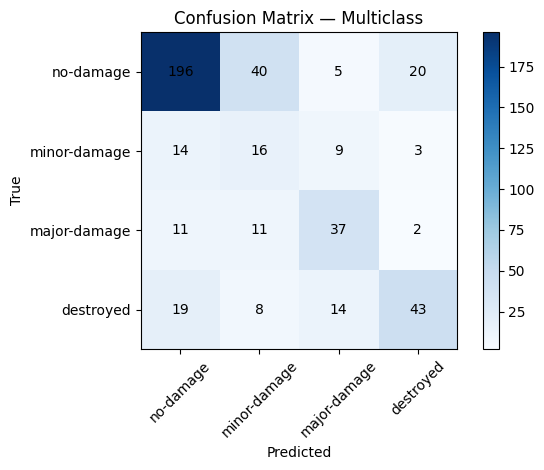

Macro-F1: 0.552 | Macro ROC-AUC (ovr): 0.816


In [82]:
# Step 5.E — evaluation
# Load best (optional, but good practice)
best_ckpt = ckpt_path  # make Step-5.E use the same, correct path
model.load_state_dict(torch.load(best_ckpt, map_location=device))
model.eval()

y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        logits = model(xb)
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        preds  = probs.argmax(1)

        y_prob.append(probs)
        y_pred.append(preds)
        y_true.append(yb.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_prob = np.concatenate(y_prob)

print(classification_report(y_true, y_pred, target_names=CLASSES, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks(range(len(CLASSES)), CLASSES, rotation=45)
plt.yticks(range(len(CLASSES)), CLASSES)
for i in range(len(CLASSES)):
    for j in range(len(CLASSES)):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.title("Confusion Matrix — Multiclass")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

macro_f1 = f1_score(y_true, y_pred, average="macro")
try:
    # macro OVR ROC-AUC (requires probabilities for all classes)
    macro_roc_auc = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
except Exception:
    macro_roc_auc = float("nan")

print(f"Macro-F1: {macro_f1:.3f} | Macro ROC-AUC (ovr): {macro_roc_auc:.3f}")

In [84]:
# Step 5.F — save meta + CSV for report
meta = {
    "task": "multiclass_damage",
    "classes": CLASSES,
    "img_size": IMG_SIZE,
    "model": "resnet18",
    "checkpoint": Path(best_ckpt).name,
    "class_weights": ce_weights.detach().cpu().tolist(),
    "val_best_acc": float(best)
}
os.makedirs("disaster-ai/models/cv", exist_ok=True)
with open("disaster-ai/models/cv/resnet18_xbd_multiclass_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved meta:", meta)

# CSV (per-sample in val set)
csv_path = "disaster-ai/models/cv/val_multiclass_scores.csv"
import csv
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["row_index", "y_true"] + [f"p_{c}" for c in CLASSES] + ["y_pred"])
    idx = 0
    for probs, y in zip(np.split(y_prob, len(y_true)), np.split(y_true, len(y_true))):
        p = probs[0]
        yt = int(y[0])
        yp = int(p.argmax())
        w.writerow([idx, yt] + [float(z) for z in p] + [yp])
        idx += 1
print("Wrote:", csv_path)

Saved meta: {'task': 'multiclass_damage', 'classes': ['no-damage', 'minor-damage', 'major-damage', 'destroyed'], 'img_size': 256, 'model': 'resnet18', 'checkpoint': 'resnet18_multiclass.pt', 'class_weights': [0.5319135785102844, 1.602149248123169, 1.076748013496399, 0.7891892194747925], 'val_best_acc': 0.0}
Wrote: disaster-ai/models/cv/val_multiclass_scores.csv


In [86]:
# Step 5.G — one-image inference helper
from PIL import Image
from torchvision import transforms

# Use the same normalization you used inside the dataset
_t_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

def predict_image(path: str):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = _t_eval(img).unsqueeze(0).to(device)
    with torch.no_grad():
        p = torch.softmax(model(x), dim=1).cpu().numpy()[0]
    top = [(CLASSES[i], float(p[i])) for i in np.argsort(-p)]
    return top

# Example (put an actual post_disaster.png path)
# predict_image("disaster-ai/data/xbd/tier1/images/some_image_post_disaster.png")